# Contents:
- [1. Import Libraries & Data](#import-libraries)
- [2. Data Preprocessing](#data-preprocessing)
- [3. Models Experiments](#models)
    - [3.1 All Features](#All-Features)
    - [3.2 Feature-Selection](#Feature-Selection)
    - [3.3 Feature Selection using PCA](#Feature-Selection-PCA)
- [4. Feature Importance](#feature-importance)
- [5. Hyperparameter Tuning](#Hyperparameter-Tuning)
- [6. ANN](#ann)

<a id="import-libraries"></a>
# 1. Import Libraries & Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [3]:
data = pd.read_csv('../../data/processed/trial2.csv')

In [4]:
data.head(2)

,logkpl,Texpi,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,...,APC2D10_I_I,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X
0,-2.25,298,0,0.1998,0.039920,6.4546,17.399965,6,6,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.95,310,0,-2.8475,8.108256,35.7706,31.873067,0,0,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.shape

(450, 17538)

In [6]:
# no missing values
data.isna().sum().sum()

0

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [8]:
model_data = data.copy()

In [9]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (337, 17537) 	 Shape of y_train: (337,)
Shape of X_test: (113, 17537) 	 Shape of y_test: (113,)


<a id="models"></a>
# 3. Models Experiments

<a id="All-Features"></a>
### 3.1 All Features

In [10]:
def evaluate_model(model_df, i, model_name, model, X, y, X_test, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """

    # cross validation with 5 folds
    all_cv_5 = cross_val_score(model, X, y, cv=5, scoring="r2")
    print("all CV 5: {}".format(all_cv_5))
    # print("Mean Cross-Validation score: {}".format(all_cv_5.mean()))

    # predictions from our model
    predictions = model.predict(X_test)


    # calculating R squared and Adjusted R squared
    r_sqre = r2_score(y_test, predictions)
    n = len(y_test)
    p = X_test.shape[1] # number of independant features

    Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    


    print("=" * 40)
    model_df.loc[i] = [model_name, all_cv_5.mean(),
                    test_mae, mean_absolute_percentage_error(y_test, predictions),
                   test_mse, test_rmse, r_sqre, Adj_r2]

    return model_df

In [11]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lasso = Pipeline([
                      ("lasso", Lasso())])

pipeline_dt = Pipeline([
                     ("dt", DecisionTreeRegressor())])

pipeline_rf = Pipeline([
                     ("rf", RandomForestRegressor())])

pipeline_kn = Pipeline([
                     ("kn", KNeighborsRegressor())])

pipeline_xgb = Pipeline([
                     ("xgb", XGBRegressor())])

pipeline_gbr = Pipeline([
                     ("gbr", GradientBoostingRegressor())])

pipeline_eln = Pipeline([
                     ("eln", ElasticNet())])

pipeline_br = Pipeline([("br", BayesianRidge())])

pipeline_cat = Pipeline([
                     ("cat", CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU"))])

pipeline_lgbm = Pipeline([
                     ("lgbm", LGBMRegressor())])



# List of all the pipelines
pipelines = [pipeline_lasso, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb, pipeline_gbr,
            pipeline_eln, pipeline_br, pipeline_cat, pipeline_lgbm] # 

# Dictionary of pipelines and model types for ease of reference
pipeline_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = pipeline_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.090e+01, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.698e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.15059042 -0.26598637 -0.10376147  0.14730296  0.4609769 ]
DecisionTree
all CV 5: [ 0.42792452 -0.26523942  0.27337692 -0.40197026  0.34999483]
RandomForest
all CV 5: [0.54182229 0.6707228  0.36256743 0.54303475 0.69815492]
KNeighbors
all CV 5: [-1.03705424  0.24722184 -1.06363454 -0.51530313 -0.28853052]
XGBRegressor
all CV 5: [0.43263196 0.66446373 0.33119841 0.36834995 0.70245254]
GradientBoostingRegressor
all CV 5: [0.55297727 0.66477656 0.50418011 0.56465031 0.70350742]
Elastic Net


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.269e+01, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.222e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.30243965 -0.90868827 -0.14443897  0.20880927  0.40187096]
BayesianRidge
all CV 5: [-1.48540295e+00  2.02596290e-02  8.93603515e-03  5.54678311e-02
 -9.68611428e+04]
CatBoostRegressor
all CV 5: [0.5443414  0.59625696 0.18334008 0.52312269 0.7460181 ]
LGBMRegressor
all CV 5: [0.48260293 0.65951174 0.57688423 0.54955976 0.66796041]


In [13]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,0.017588,0.902391,0.398680,1.242886,1.114848,-0.002163,1.006441
1,DecisionTree,0.076817,0.351854,0.148908,0.249060,0.499059,0.799178,1.001291
2,RandomForest,0.563260,0.363173,0.155277,0.239094,0.488973,0.807214,1.001239
3,KNeighbors,-0.531460,0.516283,0.223767,0.503268,0.709414,0.594205,1.002608
4,XGBRegressor,0.499819,0.380484,0.162745,0.295036,0.543172,0.762107,1.001529
5,GradientBoostingRegressor,0.598018,0.354435,0.154736,0.221185,0.470303,0.821654,1.001146
6,Elastic Net,-0.148977,0.795628,0.353137,0.948442,0.973880,0.235253,1.004915
7,BayesianRidge,-19372.508714,0.430284,0.192421,0.357548,0.597953,0.711702,1.001853
8,CatBoostRegressor,0.518616,0.348559,0.146068,0.242373,0.492314,0.804570,1.001256
9,LGBMRegressor,0.587304,0.363219,0.155046,0.246675,0.496664,0.801101,1.001278


<a id="Feature-Selection"></a>
### 3.2 Feature Selection

In [19]:
import statsmodels.api as sm
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(XGBRegressor(), 
           k_features=15,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring="r2",
           cv=5)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [22]:
# try selecting more features
sfs1.k_feature_names_

In [91]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[-0.2516396273369701, 0.27393766671733033, 0.1...",0.1492,"(MDEO-11,)",0.2780,0.2163,0.1082
2,"(31, 119)","[0.12367388563522452, 0.34387498727541654, 0.3...",0.3002,"(MDEO-11, TopoPSA)",0.1356,0.1055,0.0528
3,"(31, 41, 119)","[0.30880431201754954, 0.5093647084967751, 0.43...",0.4887,"(MDEO-11, ALogp2, TopoPSA)",0.1453,0.1131,0.0565
4,"(31, 41, 64, 119)","[0.3149384870253681, 0.47418749809880567, 0.40...",0.4970,"(MDEO-11, ALogp2, khs.sOH, TopoPSA)",0.1761,0.1370,0.0685
5,"(31, 41, 64, 119, 121)","[0.30818013989611237, 0.5307275287329458, 0.49...",0.5188,"(MDEO-11, ALogp2, khs.sOH, TopoPSA, ATSc2)",0.1543,0.1201,0.0600
6,"(31, 41, 64, 68, 119, 121)","[0.38631190602867793, 0.4785935808345101, 0.55...",0.5437,"(MDEO-11, ALogp2, khs.sOH, khs.sF, TopoPSA, AT...",0.1300,0.1012,0.0506
7,"(31, 41, 46, 64, 68, 119, 121)","[0.4276249733519527, 0.5411332487952963, 0.554...",0.5688,"(MDEO-11, ALogp2, khs.dsCH, khs.sOH, khs.sF, T...",0.1134,0.0882,0.0441
8,"(31, 37, 41, 46, 64, 68, 119, 121)","[0.4222975291895883, 0.5559418995125798, 0.554...",0.5725,"(MDEO-11, MDEN-22, ALogp2, khs.dsCH, khs.sOH, ...",0.1161,0.0903,0.0452
9,"(31, 37, 41, 46, 50, 64, 68, 119, 121)","[0.4222975291895883, 0.5559418995125798, 0.554...",0.5728,"(MDEO-11, MDEN-22, ALogp2, khs.dsCH, khs.tsC, ...",0.1166,0.0907,0.0454
10,"(31, 37, 41, 46, 50, 58, 64, 68, 119, 121)","[0.4222975291895883, 0.5559418995125798, 0.554...",0.5728,"(MDEO-11, MDEN-22, ALogp2, khs.dsCH, khs.tsC, ...",0.1166,0.0907,0.0454


In [92]:
selected_features_X = X.iloc[:, list(sfs1.k_feature_idx_)]
y = model_data['logkpl']

X_train, X_test, y_train, y_test = train_test_split(selected_features_X, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (334, 15) 	 Shape of y_train: (334,)
Shape of X_test: (112, 15) 	 Shape of y_test: (112,)


In [96]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lasso = Pipeline([
                      ("lasso", Lasso())])

pipeline_dt = Pipeline([
                     ("dt", DecisionTreeRegressor())])

pipeline_rf = Pipeline([
                     ("rf", RandomForestRegressor())])

pipeline_kn = Pipeline([
                     ("kn", KNeighborsRegressor())])

pipeline_xgb = Pipeline([
                     ("xgb", XGBRegressor())])

pipeline_gbr = Pipeline([
                     ("gbr", GradientBoostingRegressor())])

pipeline_eln = Pipeline([
                     ("eln", ElasticNet())])

pipeline_br = Pipeline([("br", BayesianRidge())])

pipeline_cat = Pipeline([
                     ("cat", CatBoostRegressor(allow_writing_files=False, verbose=0))])

pipeline_lgbm = Pipeline([
                     ("lgbm", LGBMRegressor())])



# List of all the pipelines
pipelines = [pipeline_lasso, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb, pipeline_gbr,
            pipeline_eln, pipeline_br, pipeline_cat, pipeline_lgbm] # 

# Dictionary of pipelines and model types for ease of reference
pipeline_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = pipeline_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso
all CV 5: [-0.81963771 -0.01153815 -0.75995244 -0.08257966 -0.10484652]
DecisionTree
all CV 5: [0.02198035 0.51207795 0.54119389 0.25100519 0.58854763]
RandomForest
all CV 5: [0.41732027 0.50547696 0.38600842 0.50690816 0.78619444]
KNeighbors
all CV 5: [ 0.50709336  0.2753641  -0.65305324 -0.017859    0.67117349]
XGBRegressor
all CV 5: [0.41496513 0.54132132 0.24017609 0.39754819 0.73323105]
GradientBoostingRegressor
all CV 5: [0.38248739 0.51681797 0.57054046 0.50283118 0.74742101]
Elastic Net
all CV 5: [-0.62433667  0.1134655  -0.57876155  0.24131705  0.06791585]
BayesianRidge
all CV 5: [ 0.198624    0.17515757  0.3955849  -0.08435315  0.53257089]
CatBoostRegressor
all CV 5: [0.50298672 0.53359039 0.45786051 0.50460627 0.70999299]
LGBMRegressor
all CV 5: [0.4208776  0.513767   0.32610431 0.42574016 0.76079997]


In [97]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,-0.3557,0.9262,0.7017,1.2720,1.1278,-0.0023,-0.1589
1,DecisionTree,0.3830,0.4119,0.3495,0.4157,0.6447,0.6724,0.6213
2,RandomForest,0.5204,0.4307,0.3222,0.3871,0.6222,0.6950,0.6473
3,KNeighbors,0.1565,0.4850,0.3598,0.4710,0.6863,0.6289,0.5709
4,XGBRegressor,0.4654,0.4276,0.3311,0.4062,0.6373,0.6799,0.6299
5,GradientBoostingRegressor,0.5440,0.4024,0.2770,0.3572,0.5977,0.7185,0.6745
6,Elastic Net,-0.1561,0.8749,0.6599,1.1595,1.0768,0.0864,-0.0564
7,BayesianRidge,0.2435,0.6407,0.4635,0.6987,0.8359,0.4495,0.3634
8,CatBoostRegressor,0.5418,0.3993,0.2910,0.3597,0.5997,0.7166,0.6723
9,LGBMRegressor,0.4895,0.4357,0.3120,0.3960,0.6293,0.6879,0.6392


In [98]:
calc_vif(selected_features_X)

,variables,VIF
0,nAromRings,5.5366
1,MDEO-11,10.6471
2,MDEN-11,1.3440
3,MDEN-22,2.1528
4,ALogp2,2.5775
5,khs.dsCH,1.8400
6,khs.tsC,inf
7,khs.aasC,5.6595
8,khs.tN,inf
9,khs.aasN,1.7557


<a id="Feature-Selection-PCA"></a>
### 3.3 Feature Selection using PCA

In [1]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA


# initilizing and fitting the pca
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

NameError: name 'model_data' is not defined

In [ ]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lasso = Pipeline([
                      ("lasso", Lasso())])

pipeline_dt = Pipeline([
                     ("dt", DecisionTreeRegressor())])

pipeline_rf = Pipeline([
                     ("rf", RandomForestRegressor())])

pipeline_kn = Pipeline([
                     ("kn", KNeighborsRegressor())])

pipeline_xgb = Pipeline([
                     ("xgb", XGBRegressor())])

pipeline_gbr = Pipeline([
                     ("gbr", GradientBoostingRegressor())])

pipeline_eln = Pipeline([
                     ("eln", ElasticNet())])

pipeline_br = Pipeline([("br", BayesianRidge())])

pipeline_cat = Pipeline([
                     ("cat", CatBoostRegressor(allow_writing_files=False, verbose=0))])

pipeline_lgbm = Pipeline([
                     ("lgbm", LGBMRegressor())])



# List of all the pipelines
pipelines = [pipeline_lasso, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb, pipeline_gbr,
            pipeline_eln, pipeline_br, pipeline_cat, pipeline_lgbm] # 

# Dictionary of pipelines and model types for ease of reference
pipeline_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = pipeline_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

In [ ]:
models_scores_df

<a id="feature-importance"></a>
# 4. Feature Importance

In [23]:
def plot_feature_importance(model, model_name, slice=20):
    importances = model.feature_importances_
    feature_names = X.columns#selected_features_X.columns #

    # Create a pandas DataFrame with the feature importances
    df = pd.DataFrame({"feature": feature_names, "importance": importances})

    # Sort the DataFrame by importance score
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.barplot(x="importance", y="feature", data=df[:slice])
    plt.title("Top 20 Feature Importances {}".format(model_name))
    plt.ylabel("Feature Name")
    plt.xlabel("Importance")
    plt.show()

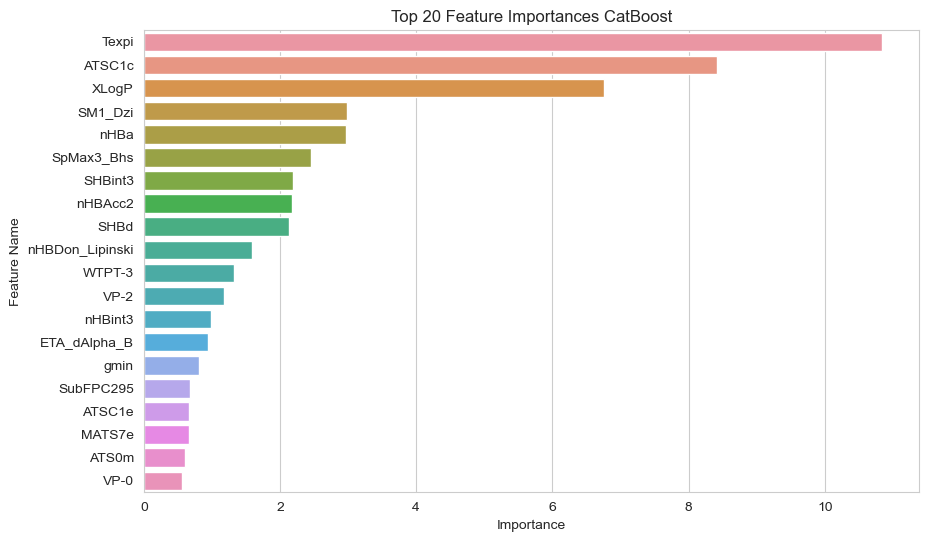

In [24]:
plot_feature_importance(pipeline_cat['cat'], "CatBoost")

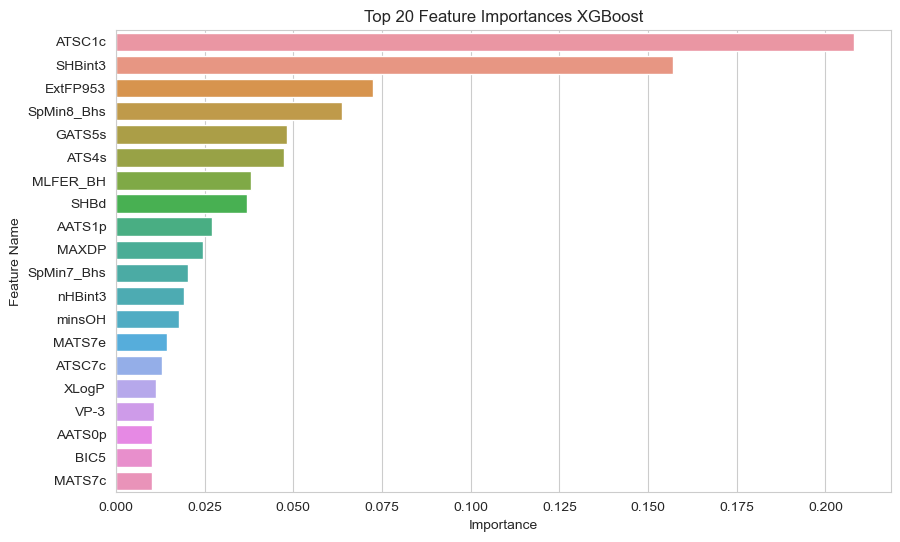

In [25]:
plot_feature_importance(pipeline_xgb['xgb'], "XGBoost")

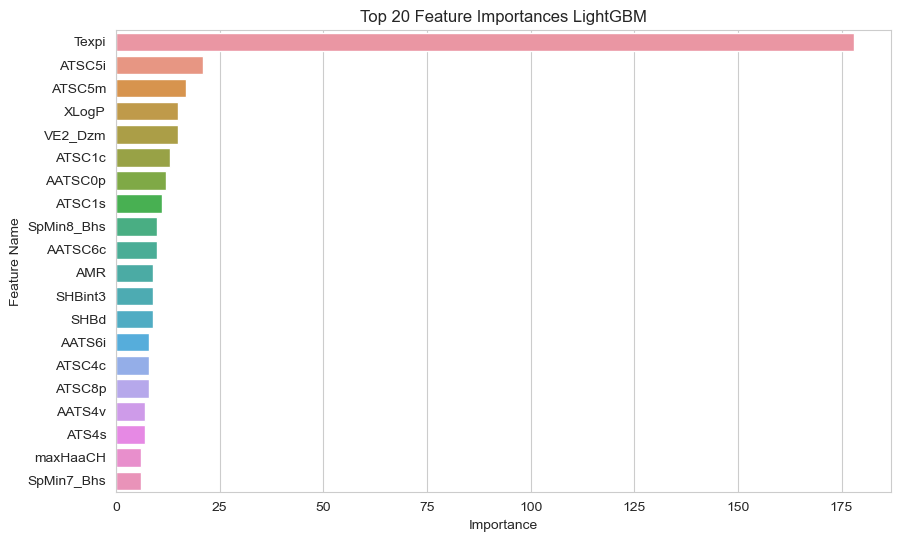

In [26]:
plot_feature_importance(pipeline_lgbm['lgbm'], "LightGBM")

<a id="Hyperparameter-Tuning"></a>
# 5. Hyperparameter Tuning

In [ ]:
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05],
                'subsample'    : [0.9, 0.5, 0.2, 0.1],
                'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10]
                }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv=5, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.02, max_depth=10, n_estimators=500,
                          subsample=0.2)

 The best score across ALL searched params:
 0.9164469215865514

 The best parameters across ALL searched params:
 {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.2}


In [38]:
RFR = RandomForestRegressor()

parameters = {'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10],
                'criterion': ["squared_error", "absolute_error"],
                'max_features': ["auto", "sqrt", "log2"],
            }

grid_RFR = GridSearchCV(estimator=RFR, param_grid=parameters, cv=5, n_jobs=-1)
grid_RFR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_RFR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_RFR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_RFR.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='sqrt')

 The best score across ALL searched params:
 0.9032530415292959

 The best parameters across ALL searched params:
 {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


In [40]:
XGB = XGBRegressor()

parameters = {
        'min_child_weight': [1, 5, 10], #50, 100
        'gamma': [0.5, 1, 2], #1.5 5
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 6, 9], # 4, 5, 8, 10
        'learning_rate': [0.001, 0.05, 0.01, 0.15],  # 0.2 0.001
        'n_estimators': [100, 500, 500] # 300 1000
        }

grid_XGB = GridSearchCV(estimator=XGB, param_grid=parameters, cv=5, n_jobs=-1)
grid_XGB.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_XGB.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_XGB.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_XGB.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

 The best score across ALL searched params:
 0.9128726597886478

 The best parameters across ALL searched params:
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500

<a id="ann"></a>
# 6. ANN

In [57]:
import tensorflow as tf

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape=[17537]))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                561216    
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 561,889
Trainable params: 561,889
Non-tr

In [59]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), verbose=2)

Epoch 1/500
11/11 - 1s - loss: 55.6749 - val_loss: 42.3931 - 990ms/epoch - 90ms/step
Epoch 2/500
11/11 - 0s - loss: 53.5944 - val_loss: 77.0709 - 145ms/epoch - 13ms/step
Epoch 3/500
11/11 - 0s - loss: 47.7563 - val_loss: 75.6626 - 142ms/epoch - 13ms/step
Epoch 4/500
11/11 - 0s - loss: 39.0366 - val_loss: 83.5861 - 167ms/epoch - 15ms/step
Epoch 5/500
11/11 - 0s - loss: 14.7401 - val_loss: 93.2204 - 136ms/epoch - 12ms/step
Epoch 6/500
11/11 - 0s - loss: 22.4626 - val_loss: 113.4421 - 123ms/epoch - 11ms/step
Epoch 7/500
11/11 - 0s - loss: 13.5492 - val_loss: 122.5143 - 133ms/epoch - 12ms/step
Epoch 8/500
11/11 - 0s - loss: 9.3386 - val_loss: 135.9437 - 133ms/epoch - 12ms/step
Epoch 9/500
11/11 - 0s - loss: 10.2986 - val_loss: 151.7192 - 131ms/epoch - 12ms/step
Epoch 10/500
11/11 - 0s - loss: 9.7555 - val_loss: 167.9326 - 178ms/epoch - 16ms/step
Epoch 11/500
11/11 - 0s - loss: 9.3900 - val_loss: 186.6964 - 192ms/epoch - 17ms/step
Epoch 12/500
11/11 - 0s - loss: 10.9505 - val_loss: 183.1724

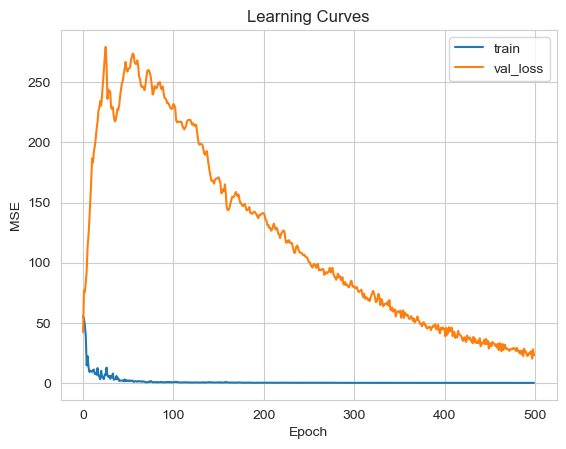

In [60]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [66]:
predictions = model.predict(X_test)

# MAE, MSE, RMSE
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("MSE: {}".format(mean_squared_error(y_test, predictions)))
print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))
print("MAPE: {}".format(mean_absolute_percentage_error(y_test, predictions)))
print("R2: {}".format(r2_score(y_test, predictions)))

4/4 [==============================] - 0s 2ms/step
MAE: 1.1132434570683842
MSE: 23.10414193590593
RMSE: 4.806676807931435
MAPE: 0.46801454084947364
R2: -17.018273935101387
